In [12]:
from langchain_cohere import ChatCohere
from dotenv import load_dotenv
import os 
load_dotenv()
CO_API_KEY = os.getenv("CO_API_KEY")

llm = ChatCohere(model="command-r-plus", cohere_api_key= CO_API_KEY)

In [13]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
import functools
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing import Literal

# start and end determine the points that workflow begins and end
from langgraph.graph import END, StateGraph, START

# Define the chains for different expert systems
expert_prompt_template = ChatPromptTemplate.from_messages(
    [("system", "{system_prompt}"), ("user", "{user_prompt}")]
)
expert_chain = expert_prompt_template | llm | StrOutputParser()

# Tools for the different job recommendation systems
@tool
def analyze_cv(user_cv: str) -> str:
    """Analyzes a user's CV/resume to identify skills, experience, and qualifications."""
    prompt = {
        "system_prompt": "You are a CV analysis expert. Extract and organize key skills, experience, education, and qualifications from the provided CV. Highlight strengths and identify potential improvement areas.",
        "user_prompt": f"Please analyze this CV and provide a structured summary: {user_cv}"
    }
    response = expert_chain.invoke(prompt)
    return response

@tool
def recommend_tech_jobs(skills: str) -> str:
    """Recommends technology and IT-related job positions based on skills."""
    prompt = {
        "system_prompt": "You are a technical recruitment specialist. Recommend suitable IT and technology job positions based on the provided skills and qualifications.",
        "user_prompt": f"Based on these technical skills, what technology jobs would be suitable? Skills: {skills}"
    }
    response = expert_chain.invoke(prompt)
    return response

@tool
def recommend_finance_jobs(skills: str) -> str:
    """Recommends finance-related job positions based on skills."""
    prompt = {
        "system_prompt": "You are a financial sector recruitment specialist. Recommend suitable finance job positions based on the provided skills and qualifications.",
        "user_prompt": f"Based on these finance skills, what jobs in the financial sector would be suitable? Skills: {skills}"
    }
    response = expert_chain.invoke(prompt)
    return response

@tool
def recommend_healthcare_jobs(skills: str) -> str:
    """Recommends healthcare-related job positions based on skills."""
    prompt = {
        "system_prompt": "You are a healthcare recruitment specialist. Recommend suitable healthcare job positions based on the provided skills and qualifications.",
        "user_prompt": f"Based on these healthcare skills, what jobs in the healthcare sector would be suitable? Skills: {skills}"
    }
    response = expert_chain.invoke(prompt)
    return response

@tool
def recommend_creative_jobs(skills: str) -> str:
    """Recommends creative industry job positions based on skills."""
    prompt = {
        "system_prompt": "You are a creative industry recruitment specialist. Recommend suitable creative job positions based on the provided skills and qualifications.",
        "user_prompt": f"Based on these creative skills, what jobs in the creative industries would be suitable? Skills: {skills}"
    }
    response = expert_chain.invoke(prompt)
    return response

@tool
def improve_cv(cv_analysis: str) -> str:
    """Provides recommendations for improving a CV based on analysis."""
    prompt = {
        "system_prompt": "You are a career counselor specializing in CV/resume improvement. Provide actionable advice to enhance the effectiveness of a CV based on the provided analysis.",
        "user_prompt": f"Based on this CV analysis, what specific improvements would you recommend? Analysis: {cv_analysis}"
    }
    response = expert_chain.invoke(prompt)
    return response

# Define our team members
members = ["CV Analyzer", "Tech Job Recommender", "Finance Job Recommender", "Healthcare Job Recommender", "Creative Job Recommender", "CV Improvement Advisor"]

# System prompt for the supervisor
system_prompt = (
    "You are a career advisor chatbot supervisor tasked with helping users find job recommendations based on their CV and skills."
    " The experts available are: {members}. Given the following user request,"
    " respond with the expert to act next. Choose 'CV Analyzer' if the user provides a CV, resume, or mentions work experience."
    " If the message includes keywords like 'my experience', 'my resume', 'years of experience', 'I have worked as', then choose 'CV Analyzer'."
    " Choose a job recommender if the user asks for job recommendations or after CV analysis is complete."
    " Choose 'CV Improvement Advisor' if the user asks for CV improvement advice."
    " Once you have a comprehensive response for the user, respond with FINISH."
)


# Options for the supervisor
options = ["FINISH"] + members

# Define the structured output for the supervisor
class RouteResponse(BaseModel):
    next: Literal[*options]
    reason: str = Field(description="Brief explanation for why this expert was chosen")

# Define the prompt for the supervisor
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}"
            " Include a brief reason for your choice.",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

# Define the supervisor agent
def supervisor_agent(state):
    print(f"[Supervisor] Deciding next step based on messages: {state['messages'][-1].content}")
    
    supervisor_chain = supervisor_prompt | llm.with_structured_output(RouteResponse)
    response = supervisor_chain.invoke(state)
    
    print(f"[Supervisor] Routing to: {response.next}")  # Log transition
    return {"next": response.next}

# Define the agent state
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

# Helper function to process tool outputs and create a response
def process_tool_output(output, expert_name):
    # Create a properly formatted message with the expert's findings
    return f"[{expert_name}]: {output}"

# Modified agent node function that handles the agent's output correctly
def agent_node(state, name):
    latest_message = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            latest_message = msg.content
            break

    if not latest_message:
        print(f"[{name}] No user message found. Routing back to Supervisor.")
        return {"messages": [AIMessage(content=f"[{name}]: I need more information to help you.")], "next": "supervisor"}

    print(f"[{name}] Processing message: {latest_message}")

    # Use the appropriate tool based on the agent type
    if name == "CV Analyzer":
        result = analyze_cv(latest_message)
    elif name == "Tech Job Recommender":
        result = recommend_tech_jobs(latest_message)
    elif name == "Finance Job Recommender":
        result = recommend_finance_jobs(latest_message)
    elif name == "Healthcare Job Recommender":
        result = recommend_healthcare_jobs(latest_message)
    elif name == "Creative Job Recommender":
        result = recommend_creative_jobs(latest_message)
    elif name == "CV Improvement Advisor":
        result = improve_cv(latest_message)
    else:
        result = f"Error: Unknown expert {name}"

    response_message = AIMessage(content=process_tool_output(result, name))
    
    print(f"[{name}] Finished processing. Returning to Supervisor.")
    return {"messages": [response_message], "next": "supervisor"}

# Create the workflow graph
workflow = StateGraph(AgentState)

# Add expert nodes
for member in members:
    workflow.add_node(member, functools.partial(agent_node, name=member))

# Add supervisor node
workflow.add_node("supervisor", supervisor_agent)

# Add entry point - start at supervisor
workflow.add_edge(START, "supervisor")

# Add edges from each expert back to supervisor
for member in members:
    workflow.add_edge(member, "supervisor")

# Create the conditional map
conditional_map = {member: member for member in members}
conditional_map["FINISH"] = END

# Add conditional edges from supervisor to each expert or end
workflow.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    conditional_map
)

# Compile the workflow (remove checkpointer if not configured)
graph = workflow.compile()  

# Example of running the workflow
def chat_with_job_bot(user_input):
    messages = [
        HumanMessage(content=user_input)
    ]
    result = graph.invoke({"messages": messages})
    # Extract the response messages from the result
    response_messages = [msg for msg in result["messages"] if isinstance(msg, AIMessage)]
    # Return the concatenated content of all assistant messages
    return "\n".join([msg.content for msg in response_messages]) if response_messages else "No response generated."

# Example usage
if __name__ == "__main__":
    print(chat_with_job_bot("Here's my CV: I have 5 years of experience as a Python developer with skills in Django, Flask, and data analysis using pandas and scikit-learn. I have a Bachelor's degree in Computer Science."))

[Supervisor] Deciding next step based on messages: Here's my CV: I have 5 years of experience as a Python developer with skills in Django, Flask, and data analysis using pandas and scikit-learn. I have a Bachelor's degree in Computer Science.
[Supervisor] Routing to: CV Analyzer
[CV Analyzer] Processing message: Here's my CV: I have 5 years of experience as a Python developer with skills in Django, Flask, and data analysis using pandas and scikit-learn. I have a Bachelor's degree in Computer Science.
[CV Analyzer] Finished processing. Returning to Supervisor.
[Supervisor] Deciding next step based on messages: [CV Analyzer]: Here is a structured summary of your CV: 

## Personal Profile: 
- An experienced Python developer with a strong background in Computer Science, aiming to secure a position where I can contribute to challenging projects and enhance my skills further. 

## Skills: 
- Proficient in Python with expertise in web development frameworks Django and Flask. 
- Well-versed in

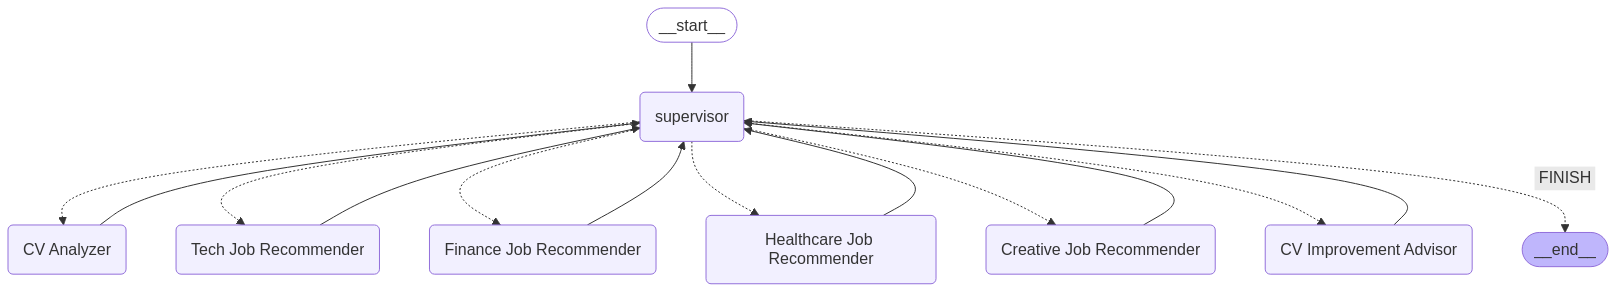

In [17]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))